### PnP ADMM

In [57]:
import numpy as np
from Unet import Unet
from pnp import pnp_admm
from utils_pnp import conv2d_from_kernel, compute_psnr, ImagenetDataset, myplot
import torch
from torch import nn
from torch.utils.data import DataLoader
from dataset import Galaxy_Dataset
import matplotlib.pyplot as plt

%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Train Unet

In [62]:
class PnP_ADMM(nn.Module):
    def __init__(self, n_iter):
        super(PnP_ADMM, self).__init__()
        self.n_iter = n_iter
    
    def forward(self, x, kernel):
        y = x
        return y

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 4)

In [60]:
class U_Update(nn.Module):
	def __init__(self):
		super(U_Update, self).__init__()

	def forward(self, x, y, rho1, M):
		t1 = rho1*x - M 
		return 0.5*(1/rho1)*( t1 + torch.sqrt( (t1**2)+4*y*rho1))

### Deconvolution

#Parameters: 31025027


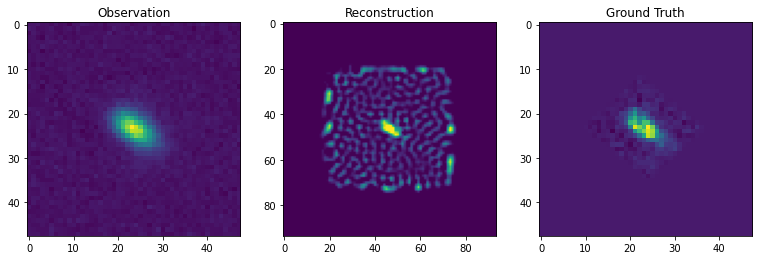

In [46]:
Dataset = Galaxy_Dataset(data_path='/Users/luke/Desktop/Galaxy-Deconvolution/dataset/',
                         COSMOS_path='/Users/luke/Desktop/Galaxy-Deconvolution/data/')
Data_loader = DataLoader(Dataset, batch_size=1, shuffle=False)
(obs, psf, M), gt = Dataset[4]

test_image = obs.repeat(1,3,1,1).to(device)
# channels, h, w = test_image.shape
forward, forward_adjoint = conv2d_from_kernel(psf, 3, device)

model = Unet(3, 3, chans=64).to(device)
model.load_state_dict(torch.load('denoiser.pth', map_location=device))
print('#Parameters:', sum(p.numel() for p in model.parameters() if p.requires_grad))

# Run plug and play
# y = forward(test_image)
y = test_image
with torch.no_grad():
    model.eval()
    x = pnp_admm(y, forward, forward_adjoint, model, num_iter=50)
    x = x.clip(0,1)

# Plot
# print('PSNR [dB]: {:.2f}'.format(compute_psnr(x, test_image)))
# myplot(obs, x[:,0,:,:], gt)
plt.figure(figsize=(13,6))
plt.subplot(1,3,1)
plt.title('Observation')
plt.imshow(obs.squeeze(dim=0).squeeze(dim=0).cpu())
plt.subplot(1,3,2)
plt.title('Reconstruction')
plt.imshow(x.squeeze(dim=0)[0,:,:].cpu())
plt.subplot(1,3,3)
plt.title('Ground Truth')
plt.imshow(gt.squeeze(dim=0).squeeze(dim=0).cpu())
plt.show()